1. Load observation images

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import pickle

import numpy as np
import pandas as pd
from PIL import Image, ImageOps
from keras.models import model_from_json
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img


In [2]:
data_folder = "../data/"
env_key = "doorkey5"
example_f = "env_0.png"

In [3]:
# load the multilabel binarizer
with open("../model/model_tokenizer.pickle", "rb") as handle:
    mlb = pickle.load(handle)
print("Feature Dictionary Loaded")
total_features = len(mlb.classes_)
print("The feature dictionary has size", total_features)
print("Features", mlb.classes_)

# load entire autoencoder architecture
json_file = open("../model/autoencoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
ae_sep_output = model_from_json(loaded_model_json)
ae_sep_output.load_weights("../model/autoencoder_model_test.h5")
print("Loaded Entire Autoencoder Model from the Disk")

# load the encoding architecture and weights
json_file = open("../model/encoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
encoding_model = model_from_json(loaded_model_json)
encoding_model.load_weights("../model/encoder_model_test.h5")
print("Loaded Encoder Model from the Disk")

# load the decoding architecture and weights
json_file = open("../model/decoder_model_test.json", "r")
loaded_model_json = json_file.read()
json_file.close()
decoding_model = model_from_json(loaded_model_json)
# load weights into new model
decoding_model.load_weights("../model/decoder_model_test.h5")
print("Loaded Decoder Model from the Disk")

Feature Dictionary Loaded
The feature dictionary has size 12
Features ['agent' 'ball' 'can_overlap' 'can_pickup' 'can_see_behind' 'door' 'empty'
 'goal' 'is_locked' 'key' 'lava' 'wall']
Loaded Entire Autoencoder Model from the Disk
Loaded Encoder Model from the Disk
Loaded Decoder Model from the Disk


In [4]:
def get_image(example):
    img_with_border = example
    img_without_border = ImageOps.crop(img_with_border, border=16)
    return img_without_border, img_with_border

    return np.array(level_image_unrolled)
def level_image_unroll(level_array_padded):
    level_image_unrolled = []
    image_h, image_w, image_c = level_array_padded.shape
    for x in range(0, image_w - 32, 16):
        for y in range(0, image_h - 32, 16):
            context_tile = level_array_padded[y: y + 48, x: x + 48, :]
            level_image_unrolled.append(context_tile)
    return np.array(level_image_unrolled)

def generate_unified_rep(example):
    level_img, level_img_padded = get_image(example)
    level_array = img_to_array(level_img)
    level_array_padded = img_to_array(level_img_padded)
    assert level_array.shape[0] % 16 == 0
    assert level_array.shape[1] % 16 == 0
    level_h = level_array.shape[0] / 16
    level_w = level_array.shape[1] / 16
    print("Height ", level_h, "Width ", level_w)
    level_image_expanded = level_image_unroll(level_array_padded)
    print("Expanded level images ", level_image_expanded.shape)

    mapped_text = np.zeros((level_image_expanded.shape[0], 12))
    encoded_level = encoding_model.predict([level_image_expanded, mapped_text])
    print("Encoding dimension", encoded_level.shape)
    tiles_sprites = [] 
    for i in range(len(encoded_level)):
        tile_embedding = encoded_level[i]
        tile_sprite = level_image_expanded[i].reshape(48, 48, 3)[16: 16 + 16, 16: 16 + 16, :]
        tiles_sprites.append(tile_sprite)
        #tiles_embeddings.append(tile_embedding)
    return tiles_sprites, encoded_level

In [5]:
example = Image.open(os.path.join(data_folder,env_key,example_f))

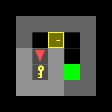

In [6]:
example

In [7]:
tiles_sprites, tiles_embeddings = generate_unified_rep(example)

Height  5.0 Width  5.0
Expanded level images  (25, 48, 48, 3)
1/1 [==============================] - 0s 63ms/step
Encoding dimension (25, 256)


In [8]:
len(tiles_sprites)

25

In [9]:
# Representation of the observation is the average embedding of the tiles
np.average(tiles_embeddings, axis = 0)

array([-0.8398002 , -0.99898267, -0.6921043 ,  0.9999945 , -0.83748746,
        0.6771853 , -0.94330305,  0.99995613,  0.9999931 , -0.6150156 ,
        0.70567137, -0.9194581 ,  0.59821546, -0.9998897 ,  0.5927398 ,
       -0.9999998 , -0.67631334,  0.63235384,  0.60245186, -0.5135426 ,
       -0.9987397 ,  0.66144586, -0.83826774,  0.9164827 , -0.9999616 ,
       -0.9993087 ,  0.75137824,  0.9999984 ,  0.7510773 ,  0.55750716,
        0.9199079 ,  0.91995096,  0.8125137 ,  0.82978266,  0.9999994 ,
        0.75922793,  0.91997194, -0.75315315,  0.99999636, -0.9165119 ,
        0.20122106,  0.64862335, -0.67770284,  0.9995986 ,  0.34403265,
       -0.752878  , -0.99994713,  0.19504412, -0.9999998 , -0.75847757,
       -0.5994766 , -0.5131537 , -0.5060488 ,  0.99998665, -0.9999494 ,
        0.99907714, -0.9199515 , -0.76118773, -0.44114587, -0.9241861 ,
        0.43889454,  0.9999871 , -0.83900404,  0.9095617 ,  0.7591889 ,
       -0.76006263, -0.75747794,  0.4251281 , -0.9997654 ,  0.43

In [10]:
decoding_img,decoding_text = decoding_model.predict(tiles_embeddings)

1/1 [==============================] - 0s 67ms/step


In [11]:
decoding_text = [np.where(text > 0.5, 1, 0) for text in decoding_text]

In [12]:
decoding_text=np.array(decoding_text)

In [13]:
mlb.inverse_transform(decoding_text)

[('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('empty',),
 ('agent',),
 ('can_pickup', 'can_see_behind', 'key'),
 ('wall',),
 ('wall',),
 ('door', 'is_locked'),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('empty',),
 ('empty',),
 ('ball', 'can_overlap', 'door', 'empty'),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',),
 ('wall',)]

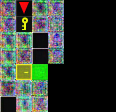

In [16]:
from keras.preprocessing.image import array_to_img, save_img, img_to_array
    
import sys
from PIL import Image

widths, heights = zip(*(array_to_img(i).size for i in decoding_img))
total_width = 96
max_height = 112

new_im = Image.new('RGB', (total_width+20, max_height))

x_offset = 0
y_offset = 0

for im in decoding_img:
    im = array_to_img(im)
    new_im.paste(im, (x_offset,y_offset))
    y_offset += im.size[1]
    if y_offset % 7 == 0:
        y_offset = 0
        x_offset += im.size[0]
    

#new_im.save('test.jpg')
new_im    

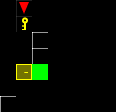

In [17]:
widths, heights = zip(*(array_to_img(i).size for i in decoding_img))
total_width = 96
max_height = 112

new_im = Image.new('RGB', (total_width+20, max_height))

x_offset = 0
y_offset = 0

for im in tiles_sprites:
    im = array_to_img(im)
    new_im.paste(im, (x_offset,y_offset))
    y_offset += im.size[1]
    if y_offset % 7 == 0:
        y_offset = 0
        x_offset += im.size[0]
    

new_im    